In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import warnings
import re
# Suppress warnings
warnings.filterwarnings("ignore")

print("Done ")

Done 


In [ ]:
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

#loading a dataframe
def load_dataframe(main_folder_path)-> pd.DataFrame:
  df_all = pd.DataFrame()
  for dirname, _, filenames in os.walk(main_path):
      paths = [dirname + '/' + filename for filename in filenames]
      folder_name = os.path.split(dirname)[-1]
      df_all = pd.concat([df_all, pd.DataFrame({'path': paths, 'class': folder_name})], ignore_index=True)

  return df_all

# Directory path
test_set_path = '/content/drive/MyDrive/archive/test'
train_set_path = '/content/drive/MyDrive/archive/train'

#creating dataframes
dfs = []
for main_path in [train_set_path, test_set_path]:
  df = load_dataframe(main_path)
  dfs.append(df)

dfs
train_df, test_df = dfs[0], dfs[1]

In [ ]:
# Define image size and batch size
imgSize = (150, 150)
batch_size = 20
randomState = seed

#combining all dfs into one to re-split w a different proportion
df_all = pd.concat([train_df, test_df], axis=0)

#splitting
from sklearn.model_selection import train_test_split
test_df, train_df = train_test_split(df_all, train_size=70, random_state=1, stratify=df_all['class'])
train_val_df, train_df = train_test_split(train_df, train_size=70, random_state=1, stratify=train_df['class'])

print(f'train ds dpts: {len(train_df)}')
print(f'train val dpts: {len(train_val_df)}')
print(f'test dpts: {len(test_df)}')
print(f'total: {len(df_all)}')


train ds dpts: 557
train val dpts: 70
test dpts: 70
total: 697


In [ ]:
#function that returns a tensorflow dataset based on a given dataframe
def create_tfDataset(dataframe: pd.DataFrame, imgSize, batchSize: int, numClasses) -> tf.data.Dataset:
    #onehot encoding the class labels
    paths = dataframe['path']
    labels = dataframe['class'].replace({'cats': 0, 'dogs': 1})

    labels = to_categorical(pd.Series.to_list(labels), num_classes=numClasses)#onehot encoding

    # Creating a new TensorFlow dataset
    tfDataframe = tf.data.Dataset.from_tensor_slices((paths, labels))
    tfDataframe = tfDataframe.map(lambda x, y: (tf.io.read_file(x), y))#reading imgs?
    tfDataframe = tfDataframe.map(lambda x, y: (tf.io.decode_jpeg(x, channels=3), y))

    # Resize images
    tfDataframe = tfDataframe.map(lambda x, y: (tf.image.resize(x, imgSize), y))

    # Caching, batching, and prefetching
    tfDataframe = tfDataframe.cache().batch(batchSize, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    return tfDataframe

In [ ]:
def augment_imgs(ds, batchSize): #this is used for a single tuple w an img and a corresponding label
t

In [ ]:
#creating datasets
test_ds = create_tfDataset(test_df, imgSize, batch_size,2)
train_ds = create_tfDataset(train_df, imgSize, batch_size,2)
train_val_ds = create_tfDataset(train_val_df, imgSize, batch_size,2)

#aumentation
train_ds = augment_imgs(train_ds, batch_size)

**Main development**

In [ ]:

## defining a function that creates the used model
def create_efficientnetb3_model(input_shape, num_classes=2):
    ## removes last layer used on ImageNet dataset classification task
    efficientnetb3_model = EfficientNetB3(include_top = False, input_shape = input_shape, pooling = 'avg')

    ## unfreezing the network weights
    efficientnetb3_model.trainable = False
    # Unfreeze only the top layers (e.g., last 10 layers)
    for layer in efficientnetb3_model.layers[-10:]:
        layer.trainable = True

    ## adapting the model to different input size
    i = Input(shape=input_shape)
    x = preprocess_input(i)
    x = efficientnetb3_model(x, training=False) ## ensures that the batch statistics estimated by the BatchNormalization layer during original model training are not changed
    x = Dense(2, activation='softmax')(x) ## new last layer to fits the task of the presented dataset
    efficientnetb3_model = Model(inputs=i, outputs=x)

    return efficientnetb3_model


In [ ]:
# Choosing initial hyperparameters to construct the baseline model
epochs = 20
lr = 0.00001  # v low learning rate

## adjusting model to the dataset/task
input_shape = imgSize + (3,) ## (150,150,3)

In [ ]:
#creating the 1st model
%%time
base_model = create_efficientnetb3_model(input_shape, num_classes = 2)
base_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │           3,074 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,786,609 (41.15 MB)

 Trainable params: 1,704,962 (6.50 MB)

 Non-trainable params: 9,081,647 (34.64 MB)

CPU times: user 1.65 s, sys: 71.5 ms, total: 1.72 s
Wall time: 1.7 s


In [ ]:
%%time
##compiling and training the model
base_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
myCallbacks= [EarlyStopping(monitor='val_loss', patience=3)]
history = base_model.fit(train_ds, validation_data=train_val_ds, epochs=epochs, batch_size=batch_size, callbacks=myCallbacks)
#history = train(base_model, epochs, lr, train_ds, train_val_ds, batch_size)#,  [EarlyStopping(monitor='val_loss', patience=5)]
#del base_model

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 382ms/step - accuracy: 0.5852 - loss: 0.6794 - val_accuracy: 0.8000 - val_loss: 0.5423
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.6478 - loss: 0.6187 - val_accuracy: 0.8333 - val_loss: 0.4985
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6623 - loss: 0.5974 - val_accuracy: 0.8667 - val_loss: 0.4592
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7409 - loss: 0.5441 - val_accuracy: 0.8667 - val_loss: 0.4264
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7537 - loss: 0.5268 - val_accuracy: 0.8833 - val_loss: 0.3970
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7562 - loss: 0.5215 - val_accuracy: 0.8833 - val_loss: 0.3713
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8309 - loss: 0.4535 - val_accuracy: 0.8833 - val_loss: 0.3480
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7864 - loss: 0.4670 - val_accuracy: 0.8833 

In [ ]:
#history = base_model.fit(train_ds, validation_data=train_val_ds, epochs=epochs, batch_size=batch_size, callbacks=myCallbacks)


In [ ]:
#using model 1 to predict on ds test1

_, accuracy_test = base_model.evaluate(test_ds)
print(f'Accuracy on test set i: {accuracy_test:.6f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9438 - loss: 0.2726
Accuracy on test set i: 0.950000


In [ ]:
#using the model to predict on ds test2

pathTest2 = '/content/drive/MyDrive/archive/test2'
test2_df = load_dataframe(pathTest2)
test2_ds = create_tfDataset(test2_df, imgSize, batch_size,2)

_, accuracy_test = base_model.evaluate(test2_ds)
print(f'Accuracy on test set ii: {accuracy_test:.6f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9334 - loss: 0.2424
Accuracy on test set ii: 0.942857


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step


<Figure size 800x600 with 0 Axes>

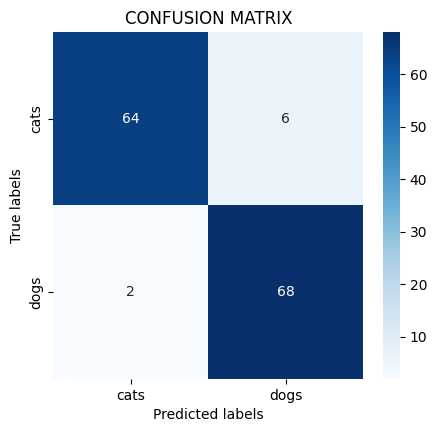

              precision    recall  f1-score   support

        cats       0.97      0.91      0.94        70
        dogs       0.92      0.97      0.94        70

    accuracy                           0.94       140
   macro avg       0.94      0.94      0.94       140
weighted avg       0.94      0.94      0.94       140



In [ ]:
# Confusion matrix plot
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


y_true = np.array(test2_df["class"].values) #numpy array w true labels

class_names = np.array(['cats', 'dogs'])
y_pred_prob = base_model.predict(test2_ds) #array w class prob predicted for each img
y_pred = np.argmax(y_pred_prob, axis=1) #transforms y_pred_prob into a 1D binary array

y_pred_labels = class_names[y_pred] #array w labels instead of binary

cf_matrix = confusion_matrix(y_true, y_pred_labels) #creates confusion matrix

plt.figure(figsize=(8, 6))
plt.figure(figsize=(5, 4.5))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', cbar=True, linecolor='k',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("CONFUSION MATRIX")
plt.show()
print(classification_report(y_true, y_pred_labels, target_names=class_names))